#### Setup for Open CV endeavour, using predictions from file "for_anil.npz" (Image & predicted mask)
1. Setup : 
    conda install -c menpo opencv3; 
    pip install imutils (Note - conda install imutils fails)
2. OpenCV version: 3.1.0 used

3.  Main concern - predicted mask for size 64 has very low sum np.sum; may I need predicted mask for entire scan in npz format (Tony/Suman has to create prediction in npz format and share the result, which I'll load and use for OpenCV countour detection and finding centriod.      

In [1]:
import cv2 # import the opencv library
import imutils
# print("Your OpenCV version: {}".format(cv2.__version__))

In [2]:
import pandas as pd
import numpy as np
import h5py
import pandas as pd
import argparse
import SimpleITK as sitk
from PIL import Image
import os, glob 
import os, os.path
import tensorflow as tf
import keras
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
%matplotlib inline

/Users/aluthra/anaconda2/envs/deeplearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/aluthra/anaconda2/envs/deeplearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
data_dir = '../data/luna16/'
npz_prediction_file = 'subset2/for_anil.npz'

In [4]:
npz_dict = np.load(data_dir + npz_prediction_file)
print ("Keys in loaded dictionary : ")
npz_dict.keys()

Keys in loaded dictionary : 


['img1',
 'prediction_mask1',
 'prediction_featuremaps0',
 'img0',
 'prediction_featuremaps1',
 'prediction_mask0']

In [5]:
img1 = npz_dict.f.img1.reshape(64,64, 64)
predicted_mask1 = npz_dict.f.prediction_mask1.reshape(64,64, 64)
featuremaps1 = npz_dict.f.prediction_featuremaps1

img0 = npz_dict.f.img0.reshape(64,64, 64)
predicted_mask0 = npz_dict.f.prediction_mask0.reshape(64,64, 64)
featuremaps0 = npz_dict.f.prediction_featuremaps0


#### Discuss : 
1. Concern the Predicted mask sum is very low for image of size 64x64x64 (refer cell below)..?

In [6]:
rounded_predicted_mask1 = np.round(predicted_mask1)
print ("Predicted mask sum (Class1) : {}".format(np.sum(predicted_mask1)))
print ("Rounded Predicted mask sum (Class1): {}".format(np.sum(rounded_predicted_mask1)))

rounded_predicted_mask0 = np.round(predicted_mask0)
print ("\nPredicted mask sum (Class0): {}".format(np.sum(predicted_mask0)))
print ("Rounded Predicted mask sum (Class0): {}".format(np.sum(rounded_predicted_mask0)))

Predicted mask sum (Class1) : 3.1760988235473633
Rounded Predicted mask sum (Class1): 0.0

Predicted mask sum (Class0): 0.005565871950238943
Rounded Predicted mask sum (Class0): 0.0


In [7]:
def displaySlice(class_type, img, mask, sliceNo):
    plt.figure(figsize=[20,20]);    
    plt.subplot(121)
    plt.title('True Image ({})'.format(class_type))
    plt.imshow(img[:, :, sliceNo], cmap='bone');
    
    plt.subplot(122)
    plt.title('Predicted Mask ({})'.format(class_type))
    plt.imshow(mask[:, :, sliceNo], cmap='bone');
#     plt.axis("off")
    plt.show()

In [8]:
interact(displaySlice,class_type=fixed('Class1'),img=fixed(img1), \
         mask=fixed(predicted_mask1), sliceNo=(0,img1.shape[2]-1,1) );
# interact(displaySlice,class_type=fixed('Class0'),img=fixed(img0), \
#          mask=fixed(predicted_mask0), sliceNo=(0,img0.shape[2]-1,1) );

##### Discussion (AL/Tony) :
1. CV2 usage - Rounded_predicted_mask1 or predicted_mask1 ....? 
2. Process 3D image in 2D slice's and then find countour in each 2D slice...? 
3. Convert image from BGR to RGB as OpenCV represents RGB images in reverse order by: 
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
4. Note the np.sum(predicted mask) is very low ~3 (concern to me)

In [9]:
#AL - should loop thru all the slice and find the slice with most 1's (white marks)
#For now using one slice i.e 2D image for CV2 as Slice# 33 has few white marks (refer slider)
test_slice = predicted_mask1[:, :, 33]   
cv2.imwrite("tst.png", test_slice)

True

In [10]:
# #AL/Tony....?
# convert image from BGR to RGB as OpenCV represents RGB images in reverse order
# cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.imread("tst.png")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

thresh_image = cv2.threshold(gray_image, 75, 255, cv2.THRESH_BINARY)[1]

# gray[25:45, 25:45]
# thresh[25:45, 25:45]   # show all zero's  though we expect One's at slice#32 around center
# cv2.imshow("testWindow", thresh_image)
## cv2.waitKey(0)

In [11]:
cnts = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]  #No contours found...?
cnts

[]

##### Above no contour found....?

In [14]:
MIN_THRESH = 9 #nodule of area 3X3 (i.e. 9mm) can be ignored

for c in cnts:
    if cv2.contourArea(c) > MIN_THRESH:
        
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        area = int(M["m00"])

        # draw the contour and center of the shape on the image
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
        cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
        cv2.putText(image, "Nodule-Centriod", (cX - 20, cY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# show the image
# cv2.imshow("Image Window", thresh_image)
# cv2.waitKey(0)

#### Result/Discussion on Erosion & Dilation operations
1. Perform dilation (to increase white region as we are getting very small sizes)
2. Then performing Erosion operation for testing

In [15]:
kernel = np.ones((7,7), np.uint8)
img_dilation = cv2.dilate(image, kernel, iterations=1)
img_erosion = cv2.erode(img_dilation, kernel, iterations=1)

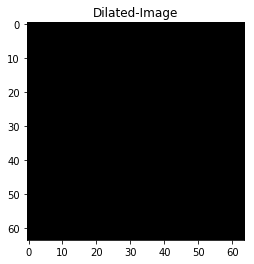

In [16]:
plt.title("Dilated-Image");
plt.imshow(img_dilation);  #noticed all the dilated images are black

In [ ]:
# interact(displaySlice,class_type=fixed('Rounded Mask -Class1'),img=fixed(img1), \
#          mask=fixed(rounded_predicted_mask1), sliceNo=(0,img1.shape[2]-1,1) );